In [13]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [14]:
import torch
torch.manual_seed(1488)

from utils import DatasetWindowed, StructuredBCELoss
from utils import make_distant_old
from utils import train_epoch, test_epoch
from torch.utils.data import DataLoader

from dataset import dataset
from monitoring import Monitor

import cpuinfo


start_idx = 80*20
scaling = 14.88

In [15]:
data_train, labels_train = dataset.load(train=True)
data_train = make_distant_old(data_train, scaling=scaling)
train_embs = DatasetWindowed(data_train, labels_train, wsize=320, stride=1, start_idx=start_idx)


print(f"Embeddings are on   device={train_embs.all_windows.device}")
print(f"emb-Labels are on   device={train_embs.all_labels.device}")

Embeddings are on   device=cpu
emb-Labels are on   device=cpu


In [16]:
data_test, labels_test = dataset.load(train=False)
data_test = make_distant_old(data_test, scaling=scaling)
test_embs = DatasetWindowed(data_test, labels_test, wsize=320, stride=1, start_idx=start_idx)


In [17]:
loader_train = DataLoader(train_embs, batch_size=32, shuffle=False)
batch = next(iter(loader_train))
batch_data, batch_target = batch
print('Train Batch')
print(f"Batch-data are on       device={batch_data.device}")
print(f"Batch-Labels are on     device={batch_target.device}")


Train Batch
Batch-data are on       device=cpu
Batch-Labels are on     device=cpu


In [18]:
loader_test = DataLoader(test_embs, batch_size=32, shuffle=False)

In [19]:
from models import MaxMapRNN

In [20]:
device = torch.device("cuda")

if device == torch.device("cpu"):
    device_desc = f"{cpuinfo.get_cpu_info()['brand_raw']}| {os.cpu_count()} threads"
    print(device_desc)
elif device == torch.device("cuda"):
    device_desc = torch.cuda.get_device_name(device)
    print(device_desc)

model = MaxMapRNN(kernel_size=4, input_size=320, hidden_size=128, rnn_layers=3).to(device)
print(model)
print(f"Num of params: {sum(p.numel() for p in model.parameters())}")

NVIDIA GeForce GTX 1660 Ti with Max-Q Design
MaxMapRNN(
  (maxmap): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (rnn): RNN(80, 128, num_layers=3, batch_first=True)
  (fc): MLP(
    (layer1): Linear(in_features=128, out_features=64, bias=True)
    (relu1): ReLU()
    (layer2): Linear(in_features=64, out_features=32, bias=True)
    (relu2): ReLU()
    (layer3): Linear(in_features=32, out_features=16, bias=True)
    (relu3): ReLU()
    (out): Linear(in_features=16, out_features=1, bias=True)
  )
)
Num of params: 103809


In [21]:
from utils import Timer

In [22]:
monitor = Monitor()
timer = Timer(timing='s')

In [23]:
num_epochs = 10
learning_rate = 0.0025
betas = (0.607, 0.999)

model.to(device)

criterion = StructuredBCELoss(pos_weight=14.88, reg_sharpness=0.00, reg_nonfaulty=0.00)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.9)

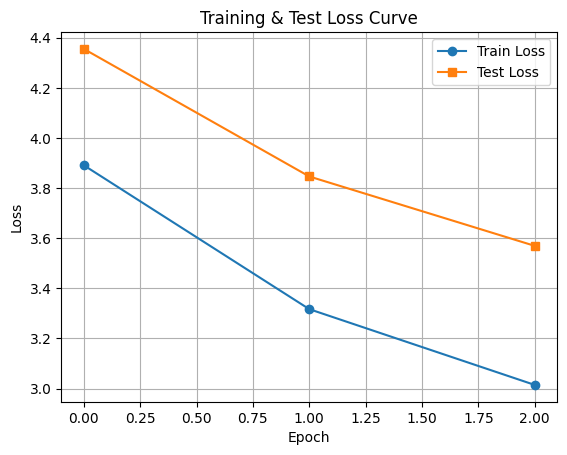

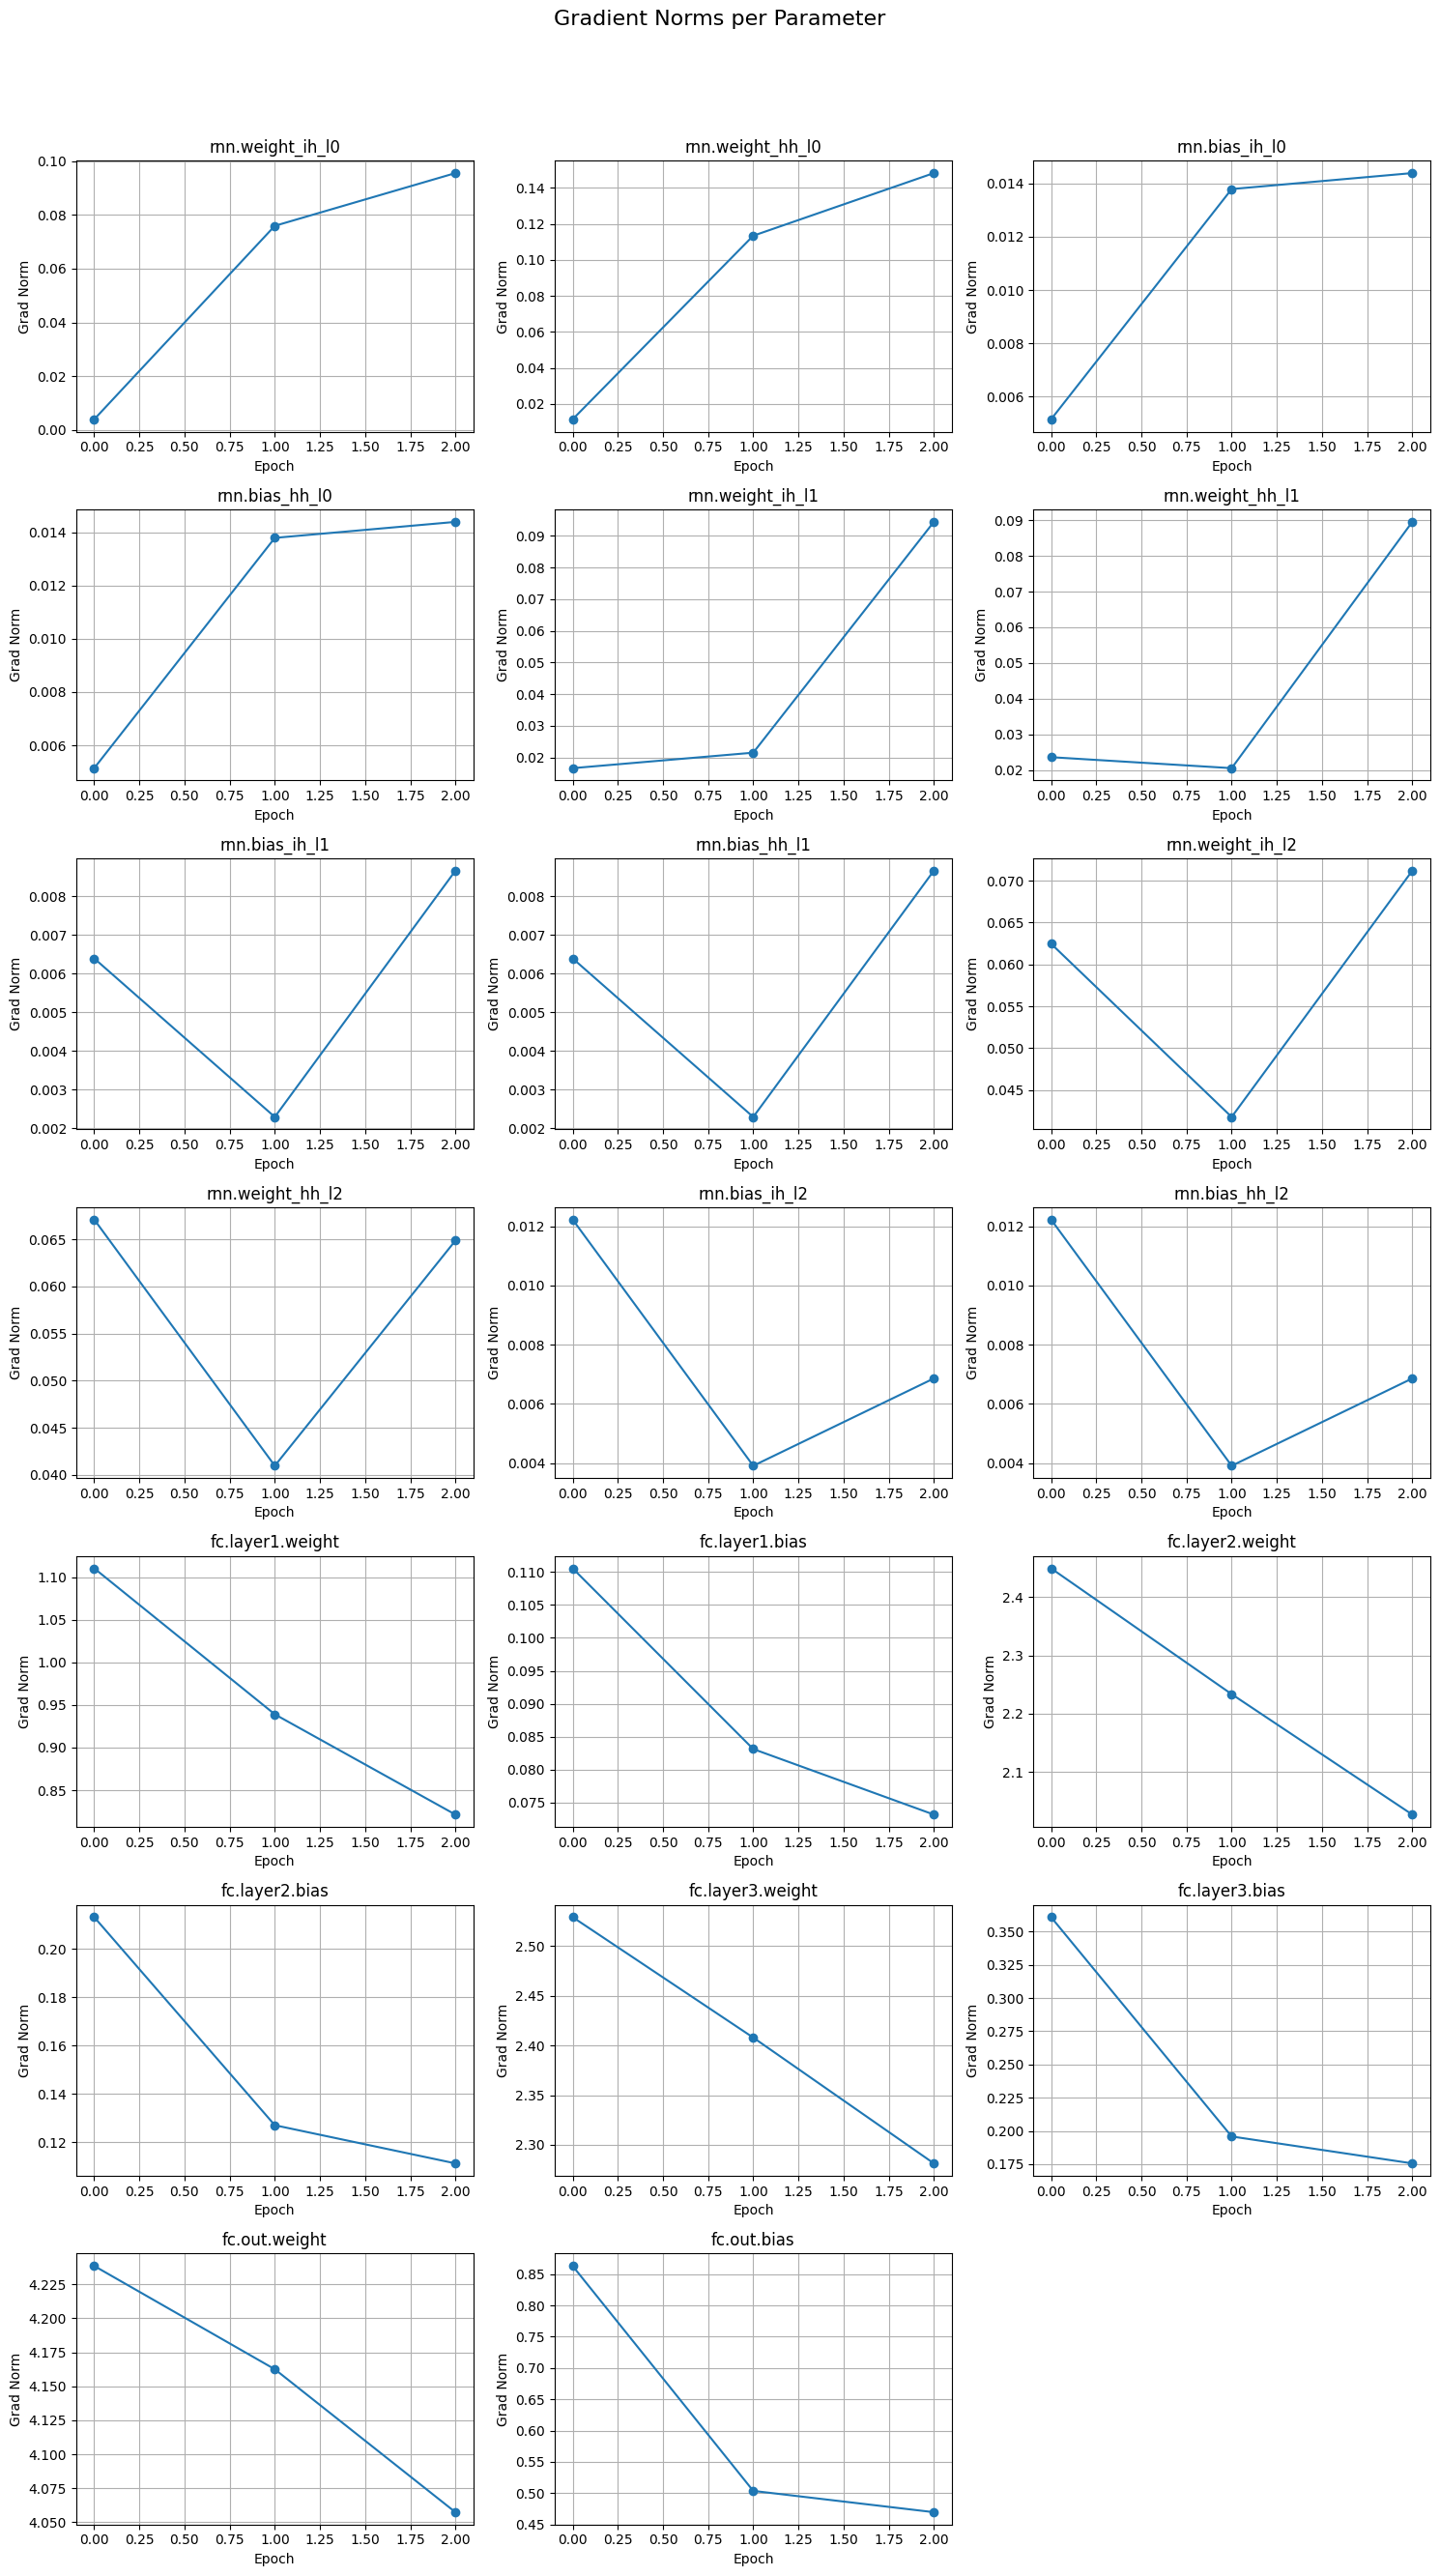

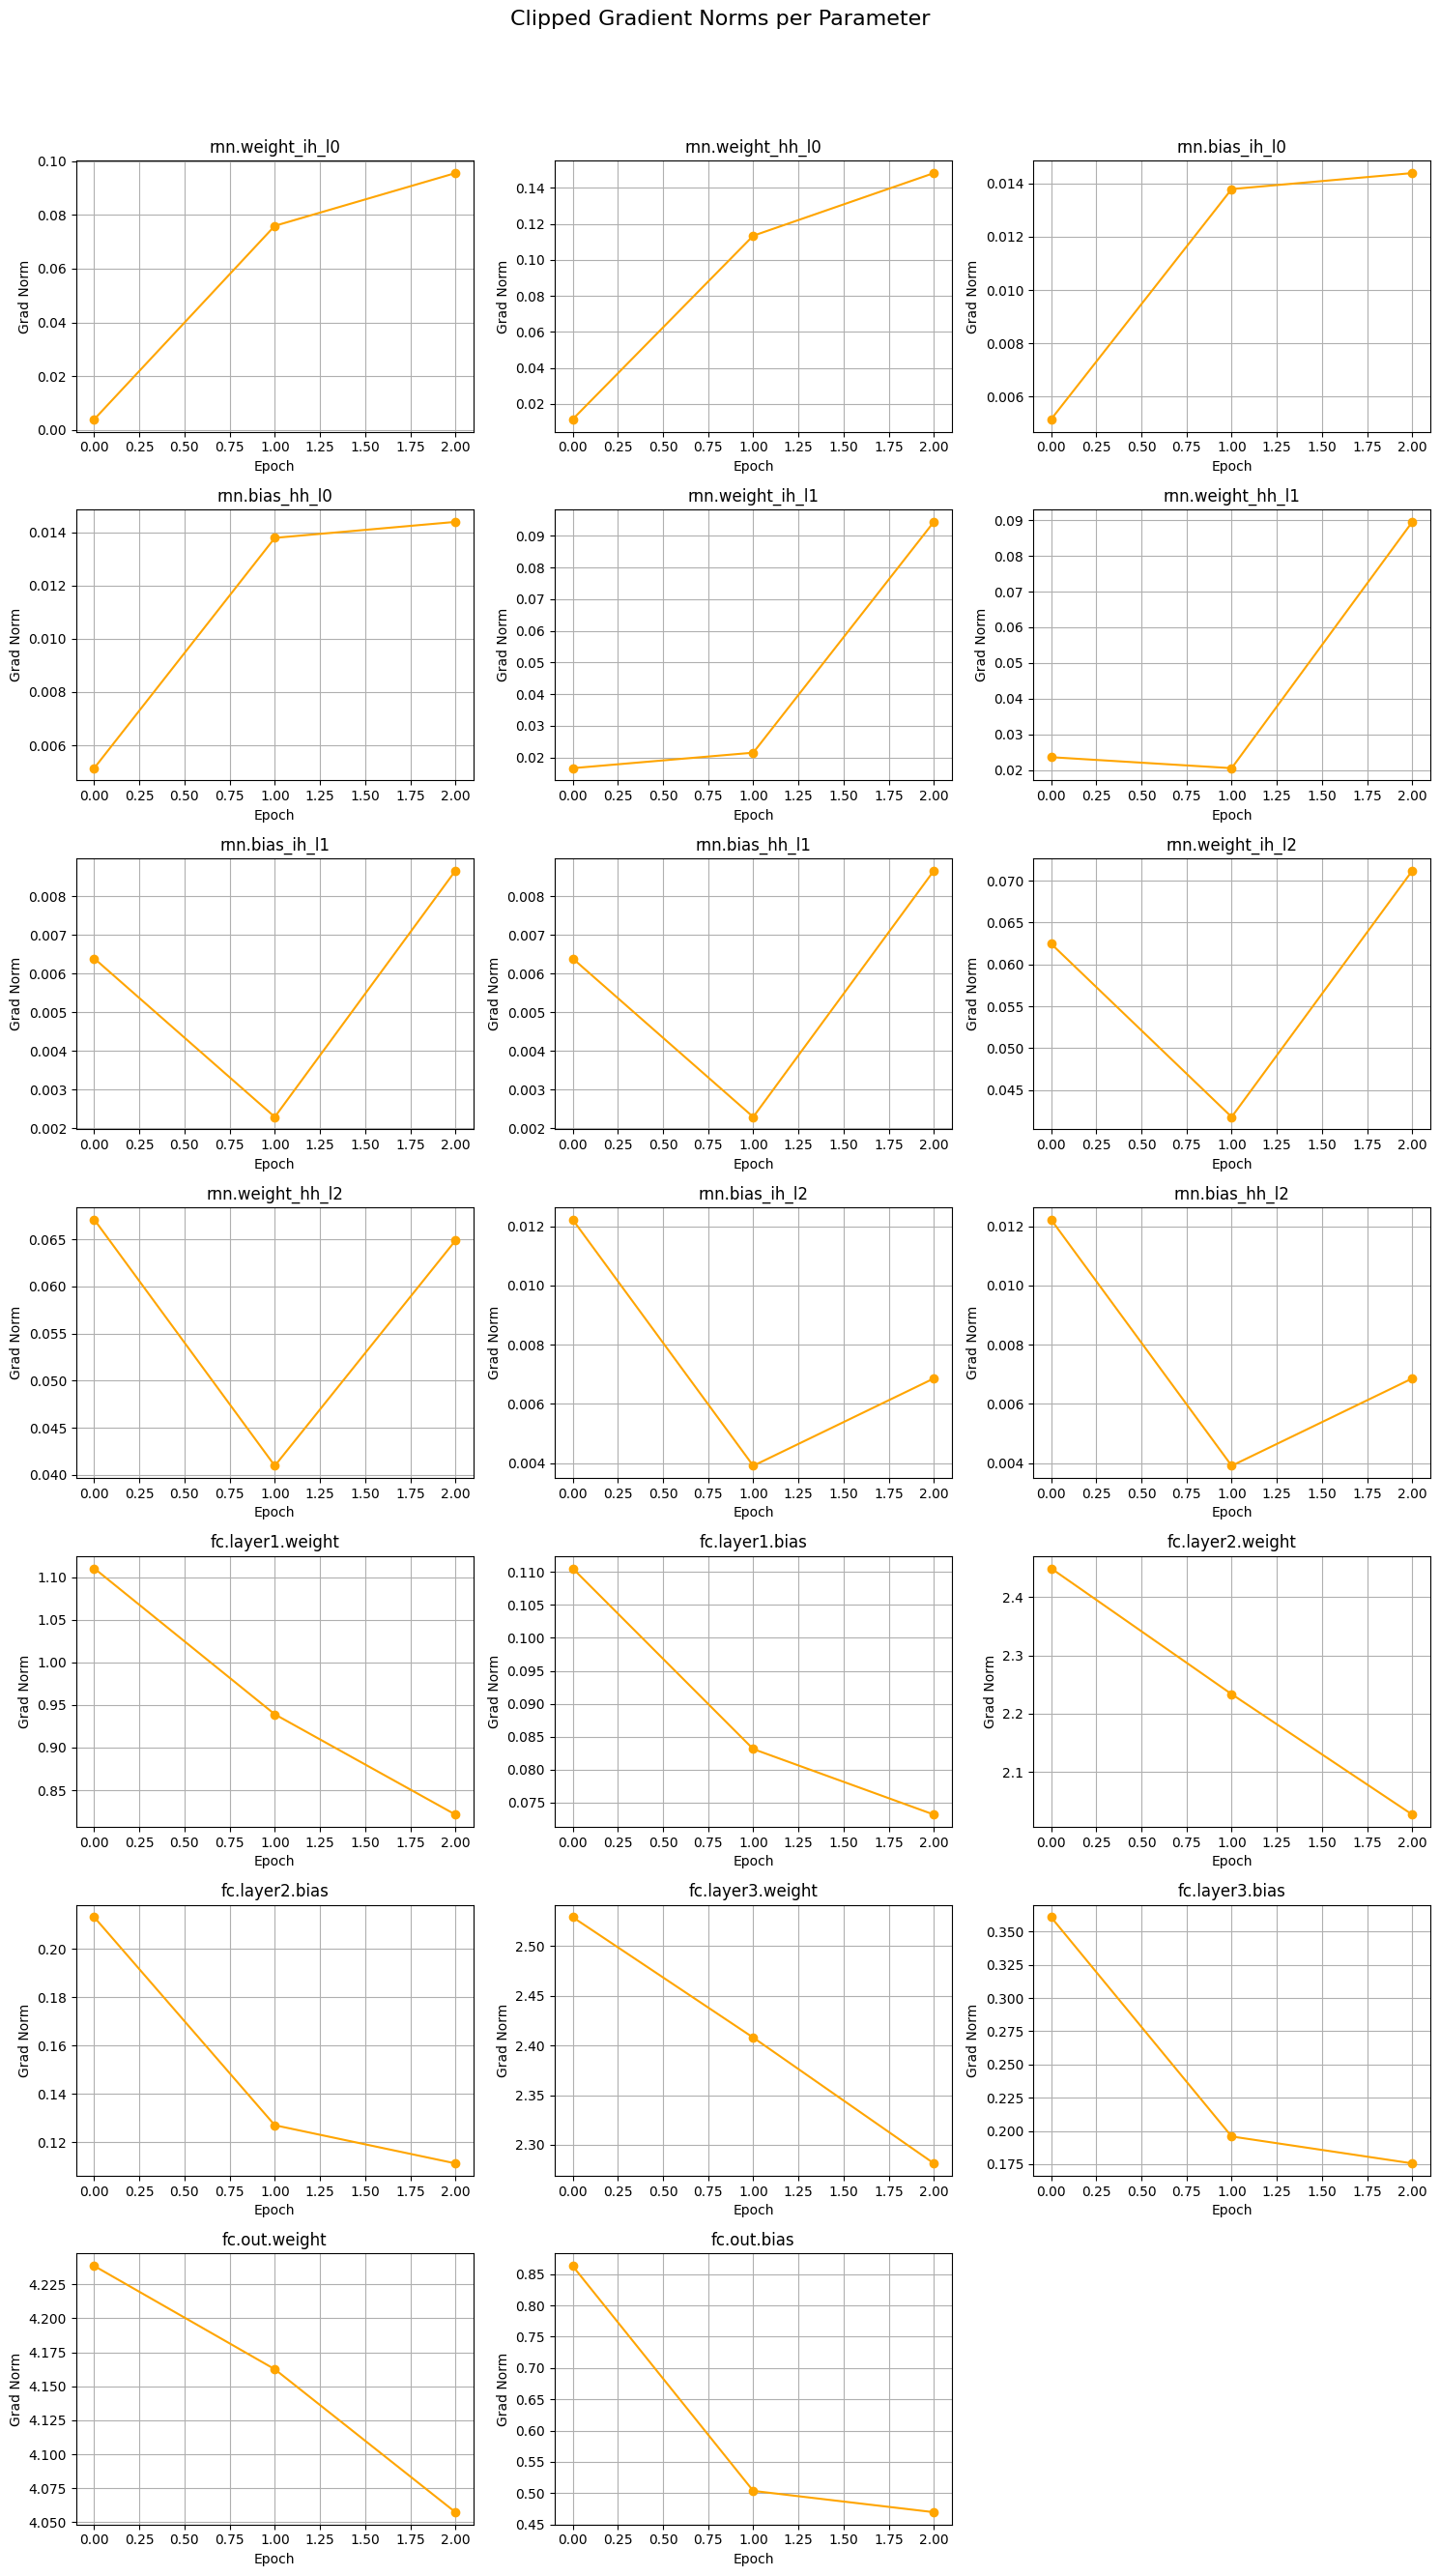

--------------------------------------------------
Epoch [4/10] | Score: 37.913%


   Training:  31%|███       | 38/124 [00:05<00:13,  6.55it/s]


KeyboardInterrupt: 

In [24]:
train_score = None
timer.tick("train")
for epoch in range(num_epochs):
    
    print("-"*50)
    score_str = f"{train_score*100:.3f}" if train_score else "||"

    print(f"Epoch [{epoch+1}/{num_epochs}] | Score: {score_str}%")


    train_loss, train_score, train_components, grad_norms, clipped_grad_norms = train_epoch(model,
                                                                        loader_train,
                                                                        criterion,
                                                                        optimizer,
                                                                        scheduler=scheduler,
                                                                        grad_clipping=None)
    
    monitor.add_train_loss(train_loss)
    monitor.add_named_loss_components(train_components, source="train")
    
    test_loss, test_score, test_components = test_epoch(model, loader_test, criterion)
    monitor.add_test_loss(test_loss)
    monitor.add_named_loss_components(train_components, source="test")
    monitor.add_gradnorms(grad_norms)
    monitor.add_clipped_gradnorms(clipped_grad_norms)
    
    names = [x[0] for x in model.named_parameters()]

    monitor.show()
    monitor.plot_gradnorms_by_param(names)
    monitor.plot_clipped_gradnorms_by_param(names)

timer.tuck("train")

In [ ]:
iter_per_sec = num_epochs / (timer.show()['train [s]']).item()

sec_per_iter = 1/iter_per_sec

print(f"Total Performance: \n   {iter_per_sec:.5f} epoch/s\n   {sec_per_iter:.5f} s/epoch")

In [ ]:
import json

filename = "./performance.json"

# Step 1: Load existing data or create new list
if os.path.exists(filename):
    try:
        with open(filename, "r") as f:
            f_json = json.load(f)
    except json.JSONDecodeError:
        f_json = []  # file is empty or invalid JSON
else:
    f_json = []

# Step 2: Append new record
f_json.append({
    "device": device_desc,
    "ep/s": iter_per_sec,
    "s/ep": sec_per_iter,
    "total_epochs": num_epochs
})

# Step 3: Write updated list back to file
with open(filename, "w") as f:
    json.dump(f_json, f, indent=4)